In [1]:
%matplotlib inline

import sys
import time
import math
import outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn import svm

import multiprocessing
import tempfile
import os
from joblib import Parallel, delayed
from joblib.pool import has_shareable_memory
cpuN = multiprocessing.cpu_count()

import warnings
warnings.filterwarnings('ignore')

prescription = pd.read_csv('data/prescriptions2017_clean.csv.gz', compression='gzip')

In [2]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.svm import OneClassSVM

def computeCLF(X,Y,epsilon,scores,clf_name):
    
    classifiers = outliers.getClassifiers(epsilon)
    
    try:
        clf = classifiers[clf_name]
        if clf_name == 'LOF':
            y_pred = clf.fit_predict(X)
        else:
            clf.fit(X)
            y_pred = clf.predict(X)

        y_pred[y_pred == 1] = 0
        y_pred[y_pred == -1] = 1
        f = f1_score(y_pred, Y)
        scores[int(epsilon*100)] = f
    except:
        scores[int(epsilon*100)] = 0

In [3]:
folder = tempfile.mkdtemp()
score_name = os.path.join(folder, 'score')

classifiers = outliers.getRanges()

mean_ep = pd.DataFrame()
mean_f = pd.DataFrame()

med = 'ANLODIPINO 10 mg CP' #X
#med = 'DICLOFENACO 50 mg CP' X
#med = 'AMPICILINA + SULBACTAM 2 g + 1 g SOL INJ' X
#med = 'VARFARINA 5 mg CP' # V
#med = 'HIOSCINA (BUTILBROMETO DE ESCOPOLAMINA) 20 mg/ml SOL INJ' # V
#med = 'TRAMADOL 50mg/ml 1ml SOL INJ'
#med = 'VITAMINAS DO COMPLEXO B CP' X

X, Y = outliers.getPrescriptions(prescription, med)
anomalies = len(Y[Y==1])
total = len(X)

print(med + ', Size: ', total, ' Overdose: ', anomalies)

for i, (clf_name, ep_range) in enumerate(classifiers.items()):

    print(clf_name)
    
    index_list = np.append([], [])
    skf = StratifiedKFold(n_splits=anomalies)
    div = 1
    for train_index, test_index in skf.split(X, Y):
        
        scores_df = pd.DataFrame()
        
        index_list = np.append(index_list.astype(int), test_index.astype(int))
        size = len(index_list)
        
        X_train = X[index_list]
        Y_train = Y[index_list]
        overdose_size = len(Y_train[Y_train==1])
        
        if (size // 100) < div:
            continue
            
        size_idx = div * 100
        div = 1 + (size // 100)
        
        sys.stdout.write(str(overdose_size) + '/' + str(size) +', ')
        
        scores = np.memmap(score_name, dtype=float, shape=(150), mode='w+')
        
        Parallel(n_jobs=cpuN)(delayed(computeCLF)(X_train, Y_train,epsilon,scores,clf_name)
                   for epsilon in ep_range)
        
        for ep in ep_range:
            idx = int(ep*100)
            scores_df.loc[clf_name,ep] = scores[idx]
        
        ep_max = scores_df.loc[clf_name].idxmax()
        mean_ep.loc[clf_name,size_idx] = float(ep_max)
        mean_f.loc[clf_name,size_idx] = scores_df.loc[clf_name].max()
        
        sys.stdout.write('('  + str(ep_max) + ',' + str(scores_df.loc[clf_name].max()) +') ')
        
        if size > 5000:
            break

    print('')

print('Done')
mean_ep

ANLODIPINO 10 mg CP, Size:  15584  Overdose:  268
DDC-H
2/118, (0.95,1.0) 4/236, (0.95,1.0) 6/354, (0.94,1.0) 7/413, (0.94,1.0) 9/531, (0.94,1.0) 11/649, (0.94,1.0) 12/708, (0.94,1.0) 14/826, (0.94,1.0) 16/944, (0.94,1.0) 17/1003, (0.94,1.0) 19/1121, (0.94,1.0) 21/1239, (0.93,1.0) 23/1357, (0.93,1.0) 24/1416, (0.93,1.0) 26/1534, (0.93,1.0) 28/1652, (0.93,1.0) 29/1711, (0.93,1.0) 31/1829, (0.93,1.0) 33/1947, (0.93,1.0) 34/2006, (0.93,1.0) 36/2124, (0.93,1.0) 38/2242, (0.93,1.0) 39/2301, (0.93,1.0) 41/2418, (0.93,1.0) 43/2534, (0.93,1.0) 45/2650, (0.93,1.0) 46/2708, (0.93,1.0) 48/2824, (0.93,1.0) 50/2940, (0.93,1.0) 52/3056, (0.93,1.0) 53/3114, (0.93,1.0) 55/3230, (0.93,1.0) 57/3346, (0.93,1.0) 58/3404, (0.93,1.0) 60/3520, (0.93,1.0) 62/3636, (0.93,1.0) 64/3752, (0.93,1.0) 65/3810, (0.93,1.0) 67/3926, (0.93,1.0) 69/4042, (0.93,1.0) 70/4100, (0.93,1.0) 72/4216, (0.93,1.0) 74/4332, (0.93,1.0) 76/4448, (0.93,1.0) 77/4506, (0.93,1.0) 79/4622, (0.93,1.0) 81/4738, (0.93,1.0) 83/4854, (0.93,1.0

2/118, (0.01,0.0333333333333) 4/236, (0.01,0.0333333333333) 6/354, (0.01,0.909090909091) 7/413, (0.01,0.923076923077) 9/531, (0.01,1.0) 11/649, (0.01,1.0) 12/708, (0.01,1.0) 14/826, (0.01,1.0) 16/944, (0.01,1.0) 17/1003, (0.01,1.0) 19/1121, (0.01,1.0) 21/1239, (0.01,0.976744186047) 23/1357, (0.01,0.978723404255) 24/1416, (0.01,0.979591836735) 26/1534, (0.01,0.981132075472) 28/1652, (0.01,0.982456140351) 29/1711, (0.01,0.983050847458) 31/1829, (0.01,0.984126984127) 33/1947, (0.01,0.985074626866) 34/2006, (0.01,0.985507246377) 36/2124, (0.01,0.986301369863) 38/2242, (0.01,0.987012987013) 39/2301, (0.01,0.987341772152) 41/2418, (0.01,0.987951807229) 43/2534, (0.01,0.988505747126) 45/2650, (0.01,0.989010989011) 46/2708, (0.01,0.989247311828) 48/2824, (0.01,0.989690721649) 50/2940, (0.01,0.990099009901) 52/3056, (0.01,0.990476190476) 53/3114, (0.01,0.990654205607) 55/3230, (0.01,0.990990990991) 57/3346, (0.01,0.991304347826) 58/3404, (0.01,0.991452991453) 60/3520, (0.01,0.99173553719) 62/36

,100,200,300,400,500,600,700,800,900,1000,...,4100,4200,4300,4400,4500,4600,4700,4800,4900,5000
DDC-H,0.95,0.95,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,...,0.93,0.93,0.93,0.93,0.93,0.93,0.93,0.93,0.93,0.93
IsoF,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Gau,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
DDC-C,0.95,0.95,0.47,0.47,0.47,0.47,0.47,0.47,0.47,0.47,...,0.47,0.47,0.47,0.47,0.47,0.47,0.47,0.47,0.47,0.47
DDC-J,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06
Cov,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.02,0.05,0.01,0.01,0.01,0.09,0.10,0.29,0.01
LOF,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
DDC-M,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98
SVM,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
DDC,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,...,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91


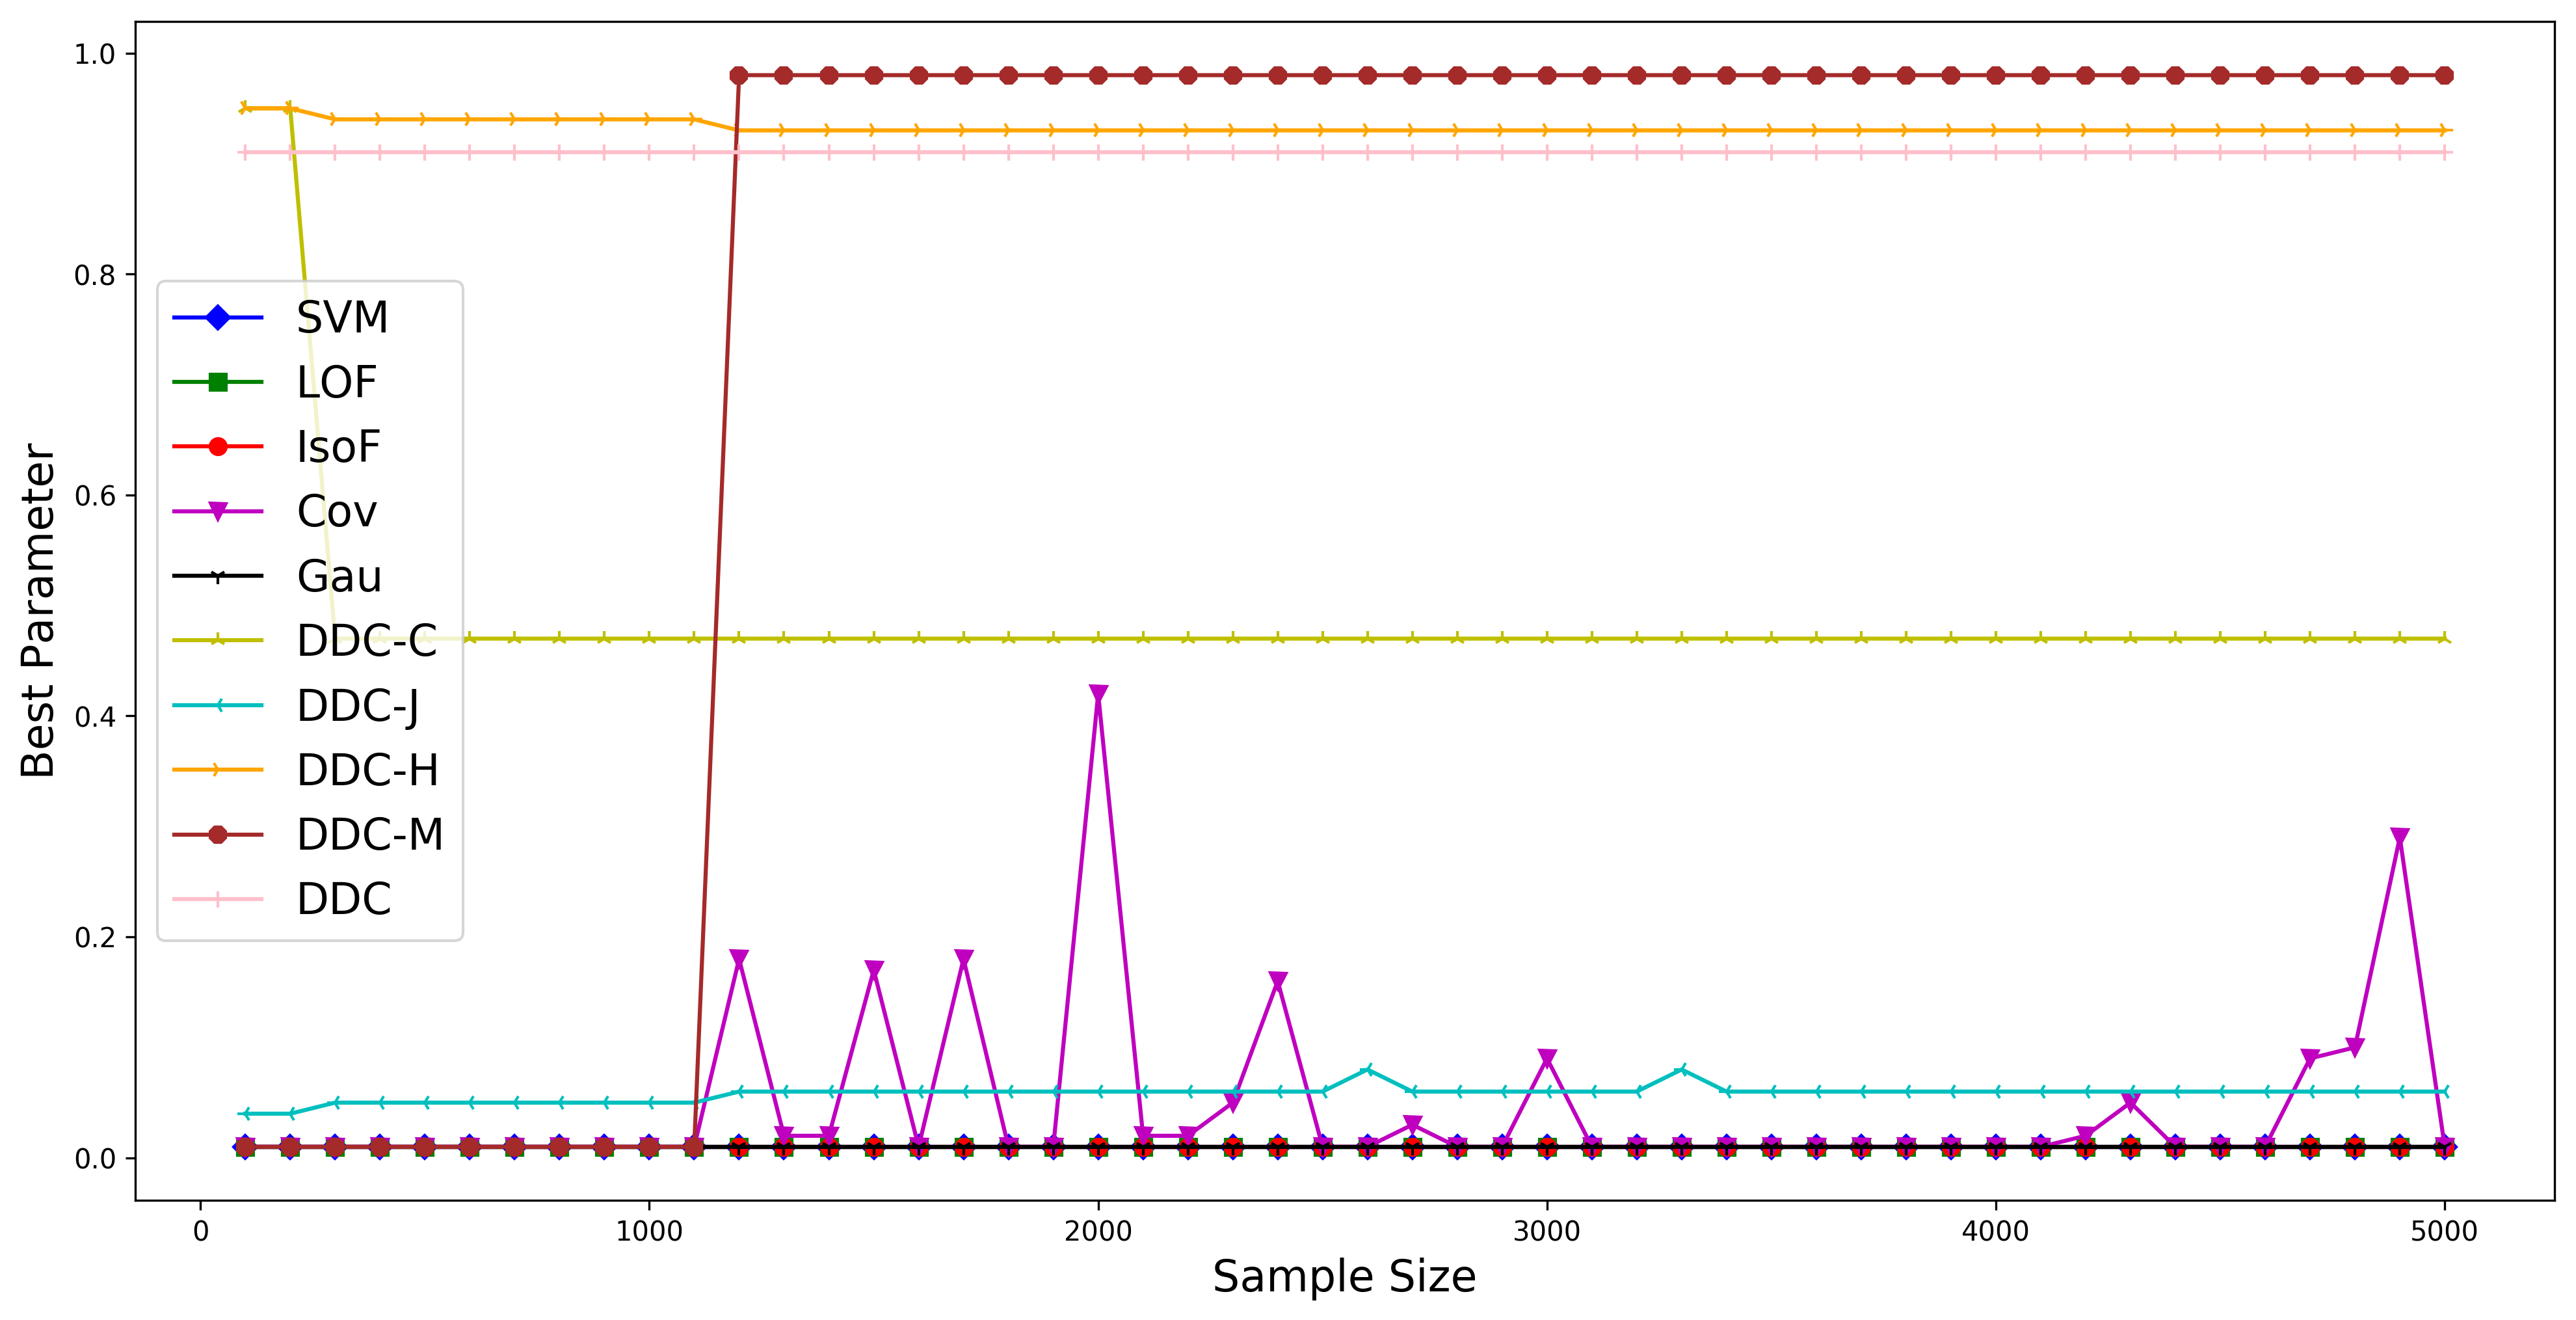

In [10]:
plt.figure(figsize=(16, 8), dpi= 300)
methods = ['SVM','LOF','IsoF','Cov','Gau','DDC-C','DDC-J','DDC-H','DDC-M','DDC']
colors = ['b', 'g', 'r', 'm', 'k', 'y', 'c', 'orange', 'brown', 'pink']
markers = ['D', 's', 'o', 'v', '1', '2', '3', '4', '8', '+']
i = 0
for m in methods:
    plt.plot(np.asarray(mean_ep.columns),np.asarray(mean_ep.loc[m].values), c=colors[i],label=m, marker=markers[i])
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Best Parameter', fontsize=16)
#plt.ylim(0,22)
#plt.xlim(0,28000)
plt.show()

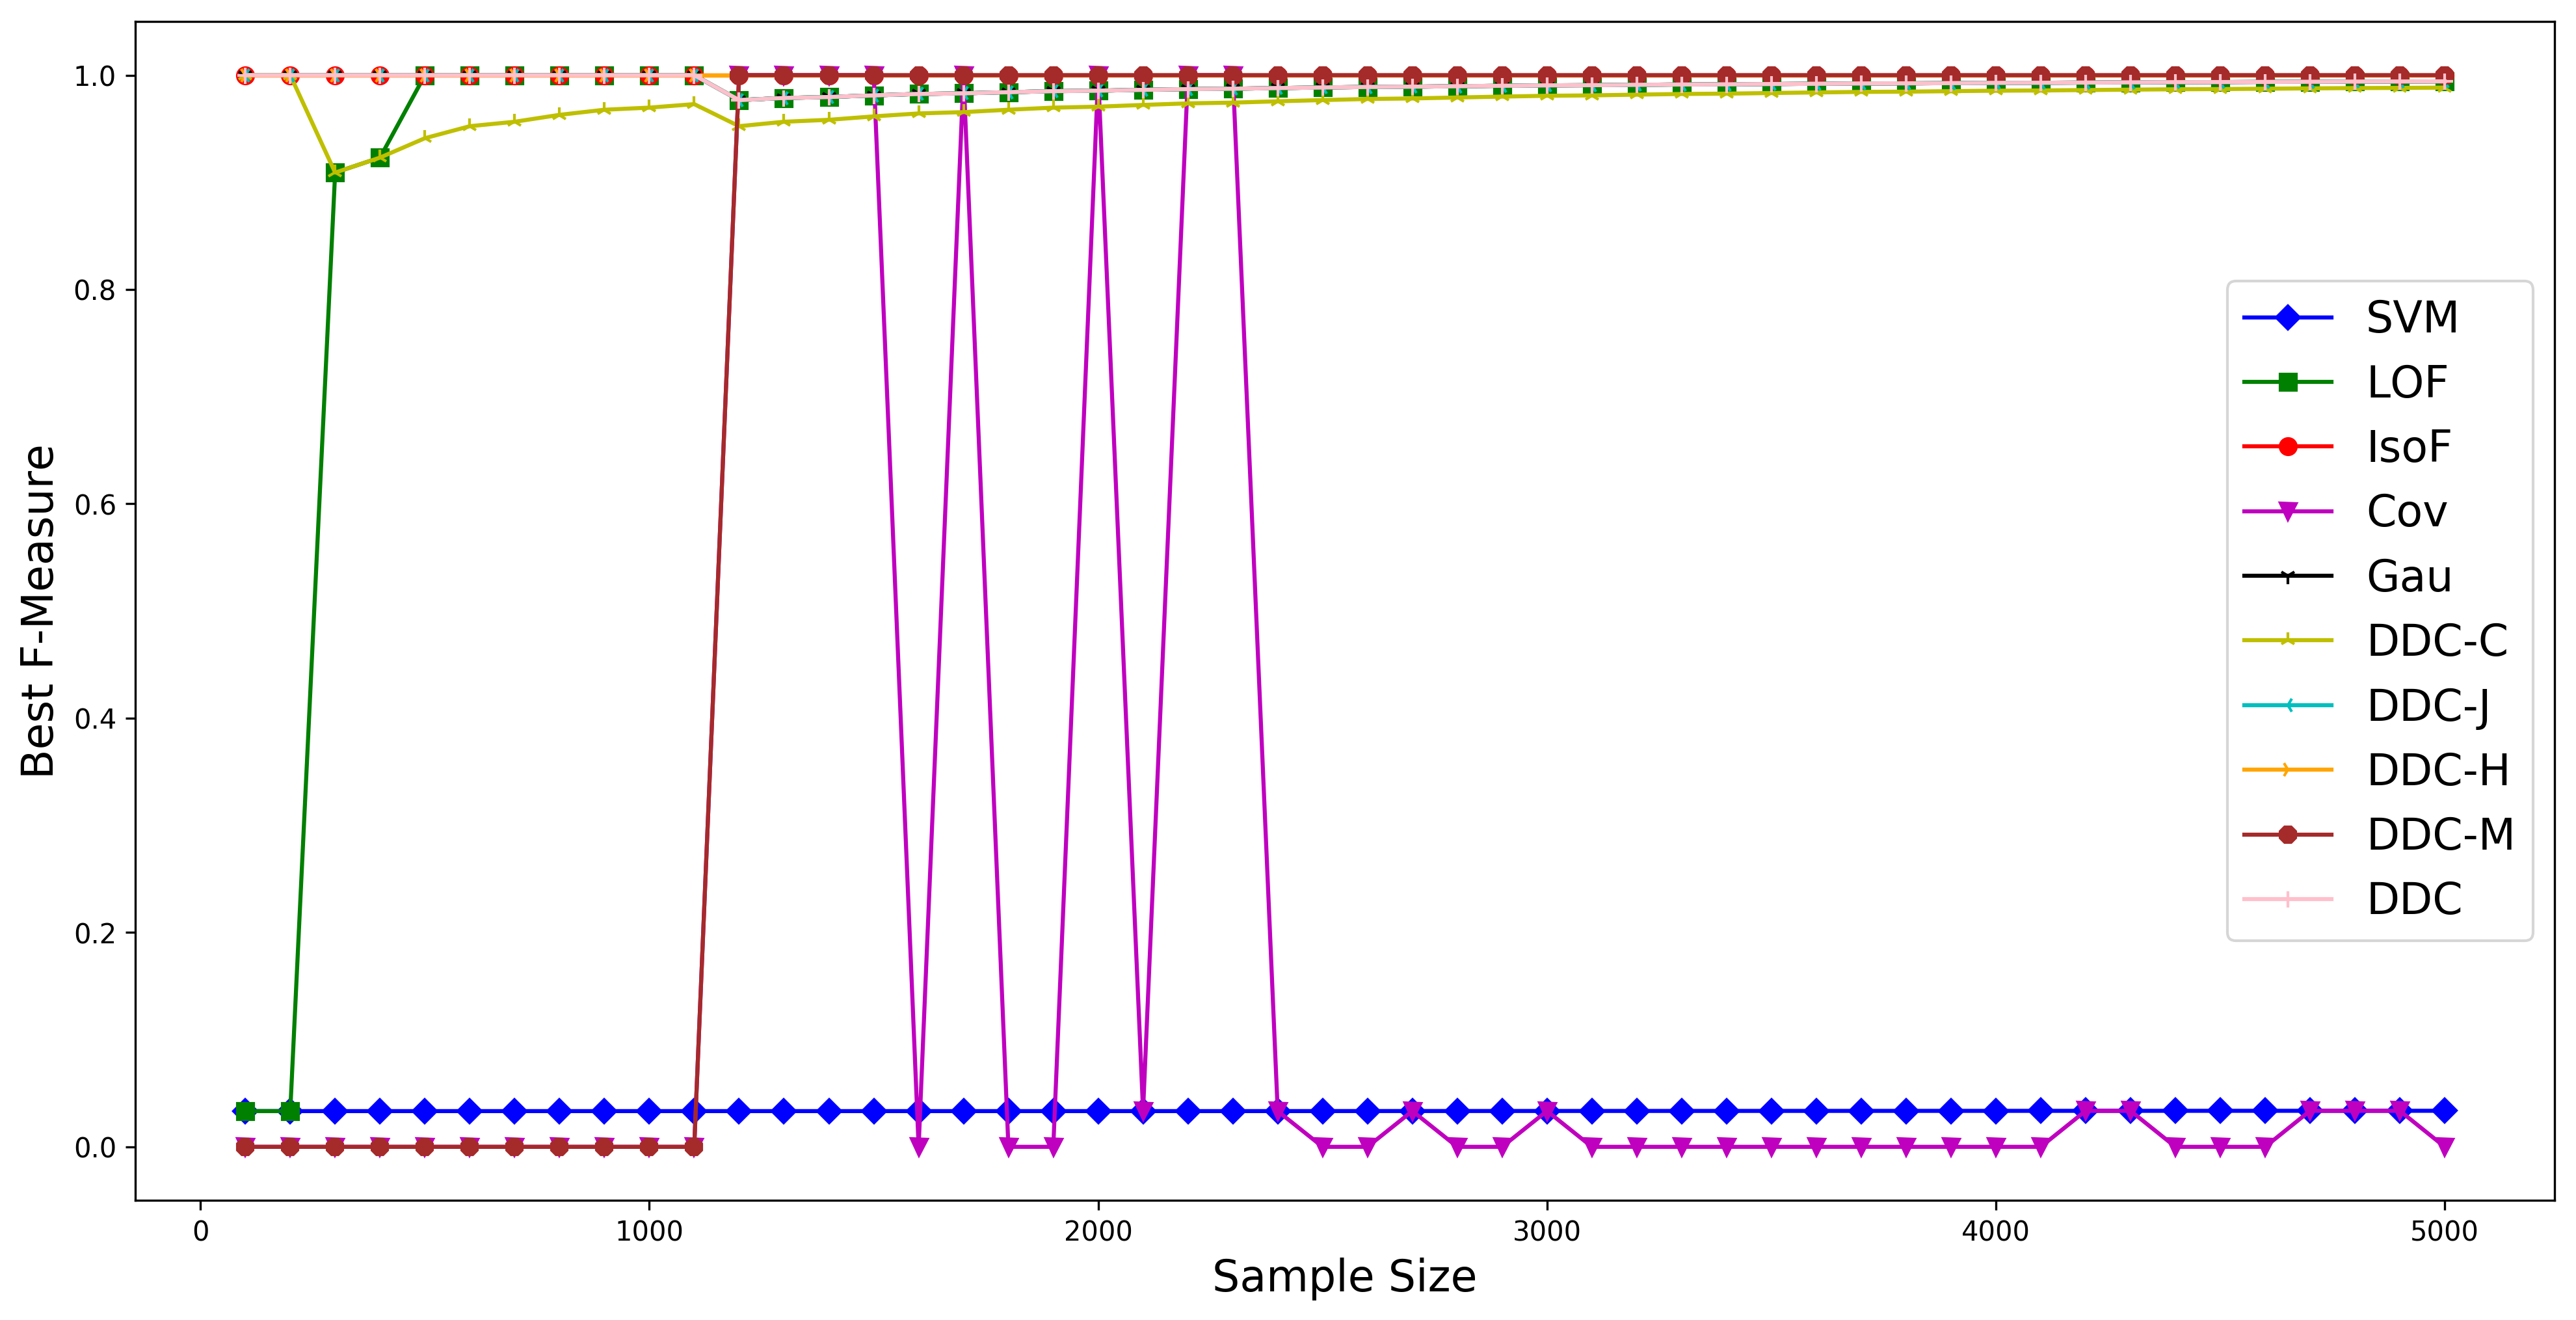

In [11]:
plt.figure(figsize=(16, 8), dpi= 300)
methods = ['SVM','LOF','IsoF','Cov','Gau','DDC-C','DDC-J','DDC-H','DDC-M','DDC']
colors = ['b', 'g', 'r', 'm', 'k', 'y', 'c', 'orange', 'brown', 'pink']
markers = ['D', 's', 'o', 'v', '1', '2', '3', '4', '8', '+']
i = 0
for m in methods:
    plt.plot(np.asarray(mean_f.columns),np.asarray(mean_f.loc[m].values), c=colors[i],label=m, marker=markers[i])
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Best F-Measure', fontsize=16)
#plt.ylim(0,22)
#plt.xlim(0,28000)
plt.show()